In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from misc import data
import seaborn as sns
sns.set_style('whitegrid')

## 1. Comparing 8, 16 and 32 latent size

In [2]:
def plot_spearman(file_list, labels=None, save_name=None, **kwargs):
    
    plt.figure(figsize=(10, 7))
    
    for i, file in enumerate(file_list):
        model_dict = torch.load(file)
        plt.plot(model_dict['stats']['cor'], lw=2, c=f'C{i}', label="Our result" if labels is None else labels[i])
    
    plt.title(r"$|Spearman\ \rho|$ correlation to experimental data", size=26)
    plt.xlabel('Epoch', size=24)
    plt.ylabel(r'Spearman Correlation $\rho$', size=24)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    if 'xlim' in kwargs.keys():
        plt.xlim(kwargs['xlim'])
        
    if 'ylim' in kwargs.keys():
        plt.ylim(kwargs['ylim'])
    
    plt.legend(prop={'size': 22})
    
    if save_name:
        plt.savefig(f'saved_figs/{save_name}.png', bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()

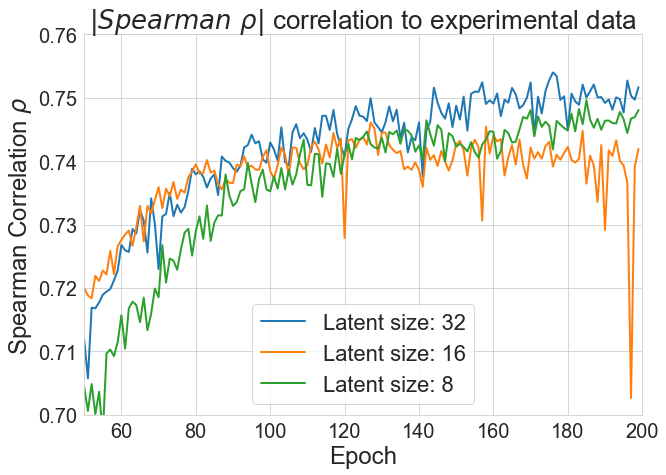

In [8]:
file_list = ['models/ep200_hs2000_e512_ls32.model.pth',
             'models/ep200_hs2000_e512_ls16.model.pth',
             'models/ep200_hs2000_e512_ls8.model.pth']
labels = ['Latent size: 32', 'Latent size: 16', 'Latent size: 8']

kwargs = {
    'xlim': (50, 200),
    'ylim': (0.70, 0.76)
}

plot_spearman(file_list, labels, 'latent_comparison', **kwargs)

## 2. Compare to VAE with dropout

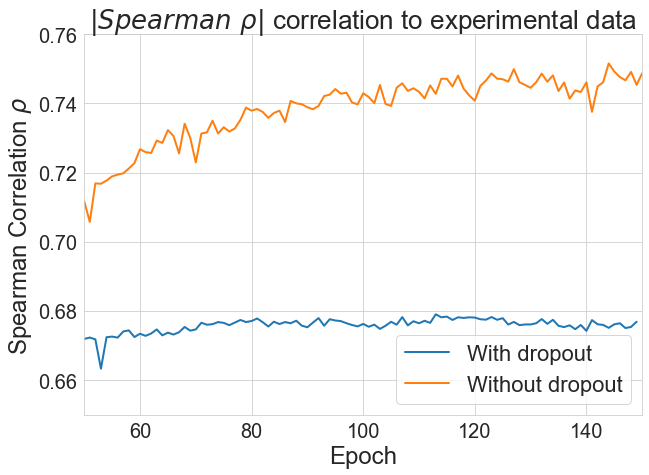

In [19]:
file_list = ['models\ep150_hs2000_e512_ls32_dropout.model.pth',
             'models\ep200_hs2000_e512_ls32.model.pth']
labels = ['With dropout', 'Without dropout']

kwargs = {
    'xlim': (50, 150),
    'ylim': (0.65, 0.76)
}

plot_spearman(file_list, labels, 'dropout_comparison', **kwargs)

## 3. Different init 

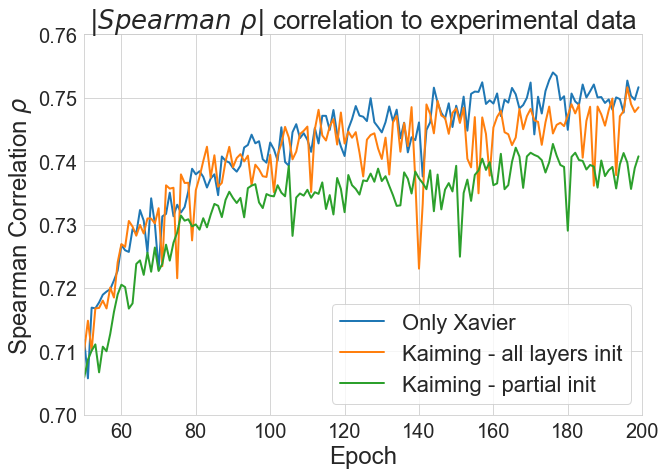

In [20]:
file_list = ['models\ep200_hs2000_e512_ls32.model.pth',
             'models\ep200_hs2000_e512_ls32_kaiming_allinit.model.pth',
             'models\ep200_hs2000_e512_ls32_kaiming_partialinit.model.pth']

labels=['Only Xavier',
        'Kaiming - all layers init', 
        'Kaiming - partial init']

kwargs = {
    'xlim': (50, 200),
    'ylim': (0.70, 0.76)
}

plot_spearman(file_list, labels, 'weight_init_comparison', **kwargs)

### Notes:
We see that it's important to initialize all layers, also group sparsity and latent space. 

For Kaiming you would normally set the bias to zero, but we don't do that in our models, as a zero bias init would focus on the KL and not the reconstruction.

So we see that it doesn't matter what kind of initialization we use (?)

## 4. Basic N-VAE vs Basic S-VAE

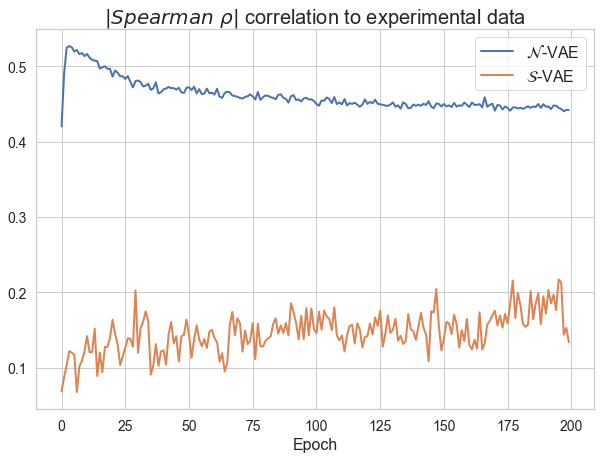

In [61]:
file_list = ['models\Basic_Nvae_ep200_hs64_ls2.model.pth', 
             'models\Basic_SVAE_ep200_hs64_ls2.model.pth']

labels = [r'$\mathcal{N}$-VAE', r'$\mathcal{S}$-VAE']

'''kwargs = {
    'xlim': (50, 200),
    'ylim': (0.70, 0.76)
}
'''

plot_spearman(file_list, labels)

### 4.1 Normal latent space representation

In [4]:
from N_VAE.vae_basic import Basic_VAE
from S_VAE.S_vae_basic import Basic_S_VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dict_N = torch.load('models\Basic_Nvae_ep200_hs64_ls2.model.pth')
dataloader_N, df_N, _, _ = data(weighted_sampling=False)

model_dict_S = torch.load('models\Basic_SVAE_ep200_hs64_ls2.model.pth')
dataloader_S, df_S, _, _ = data(device=device, weighted_sampling=False)

Parsing fasta 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105.a2m'
Parsing labels 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_LABELS.a2m'
Generating 8403 1-hot encodings
Generating 8403 1-hot encodings. Took 0.679s torch.Size([8403, 23, 253])
Dataset - Not weighted
Generating 4807 1-hot encodings
Generating 4807 1-hot encodings. Took 0.435s torch.Size([4807, 23, 253])
Parsing fasta 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105.a2m'
Parsing labels 'data/BLAT_ECOLX_hmmerbit_plmc_n5_m30_f50_t0.2_r24-286_id100_b105_LABELS.a2m'
Generating 8403 1-hot encodings
Generating 8403 1-hot encodings. Took 0.715s torch.Size([8403, 23, 253])
Dataset - Not weighted
Generating 4807 1-hot encodings
Generating 4807 1-hot encodings. Took 0.443s torch.Size([4807, 23, 253])


Size of latent space: 2


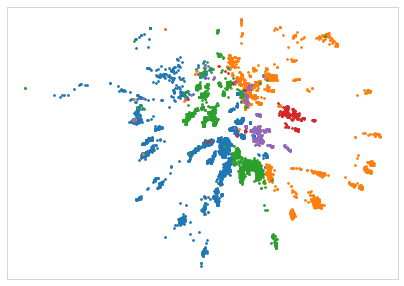

In [136]:
fig = plt.figure(figsize=(7, 5))

''' Normal latent space '''
ax1 = fig.add_subplot(111)
#ax1.axis("off")

mask = df_N['label'].isin(df_N['label'].value_counts()[:5].index) # We limit to top 5 classes only
vae = Basic_VAE(**model_dict_N['args'])
vae.load_state_dict(model_dict_N['state_dict'])
vae.eval()
_, mu, logvar = vae(dataloader_N.dataset[mask])
columns = [str(i+1) for i in range(mu.shape[1])] + ['label']

dfp = pd.DataFrame(data=np.c_[mu.detach().numpy(), df_N[mask]['label']], columns=columns)

for protein in dfp['label'].unique():
    label_filter = dfp['label'] == protein
    plt.scatter(dfp[label_filter]['1'], dfp[label_filter]['2'], s=3, label=protein)


#lgnd = plt.legend(loc="lower left", fontsize=14)
#for l in lgnd.legendHandles:
#    l._sizes = [100]

#plt.tick_params(axis='both', labelsize=15)
#plt.title("Latent space")
plt.grid(False)
plt.xticks([])
plt.yticks([])
#plt.figtext(0.5, 0.05, "a) test", ha="center", fontsize=14)

plt.savefig(f'saved_figs/NVAElatent.png', bbox_inches = 'tight', pad_inches = 0.05)

plt.show()

### 4.2 Hyperspherical latent representation

#### 4.2.1 Latent space in 2D

Size of latent space: 2


d:\github\variational-proteins\venv\lib\site-packages\torch\distributions\distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


label
Actinobacteria    AxesSubplot(0.125,0.125;0.775x0.755)
Bacteroidetes     AxesSubplot(0.125,0.125;0.775x0.755)
Cyanobacteria     AxesSubplot(0.125,0.125;0.775x0.755)
Firmicutes        AxesSubplot(0.125,0.125;0.775x0.755)
Proteobacteria    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 2, dtype: object

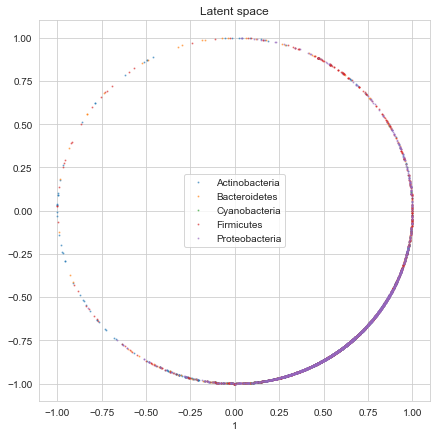

In [70]:
''' 2D Hyperspherical latent space '''
plt.figure(figsize=(7, 7))
plt.title("Latent space")
mask = df['label'].isin(df['label'].value_counts()[:5].index) # We limit to top 5 classes only
vae = Basic_S_VAE(**model_dict_S['args']).to(device)
vae.load_state_dict(model_dict_S['state_dict'])
vae.eval()
_, mu, logvar, q_z, p_z = vae(dataloader_S.dataset[mask])
columns = [str(i+1) for i in range(mu.shape[1])] + ['label']
dfp = pd.DataFrame(data=np.c_[mu.detach().numpy(), df[mask]['label']], columns=columns)
dfp = dfp.set_index('1').groupby('label')['2']
dfp.plot(style='.', ms=2, alpha=0.5, legend=True)

#### 4.2.2 Latent space in 3D

In [5]:
model_dict_S2 = torch.load('models\Basic_SVAE_ep200_hs64_ls3.model.pth')

Size of latent space: 3


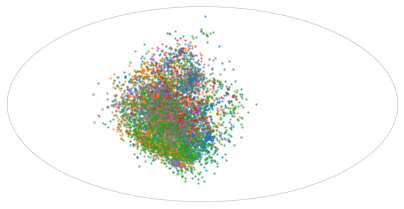

In [135]:
''' Hammer projection of 3D hyperspherical latent space '''
fig = plt.figure(figsize=(7, 5))
ax2 = fig.add_subplot(111, projection='hammer')

mask = df_S['label'].isin(df_S['label'].value_counts()[:5].index) # We limit to top 5 classes only
vae = Basic_S_VAE(**model_dict_S2['args']).to(device)
vae.load_state_dict(model_dict_S2['state_dict'])
vae.eval()
_, mu, logvar, q_z, p_z = vae(dataloader_S.dataset[mask])
columns = [str(i+1) for i in range(mu.shape[1])] + ['label']

dfp = pd.DataFrame(data=np.c_[mu.detach().numpy(), df_S[mask]['label']], columns=columns)

dfp['1'] = dfp['1'].astype('float')
dfp['2'] = dfp['2'].astype('float')
dfp['3'] = dfp['3'].astype('float')

x, y, z = dfp['1'].values, dfp['2'].values, dfp['3'].values

# https://vvvv.org/blog/polar-spherical-and-geographic-coordinates
dfp['lat'] = np.arcsin(z/(np.sqrt(x**2 + y**2 + z**2)))
dfp['lon'] = np.arctan2(y, x)

#dfp['lon'] = 2*np.arctan((dfp['3'].values*dfp['1'].values)/(2*(2*dfp['3'].values**2 - 1)))
#dfp['lat'] = np.arcsin(dfp['3'].values*dfp['2'].values)

lat = dfp['lat'].values
lon = dfp['lon'].values

dfp['x'] = (2*np.sqrt(2)*np.cos(lat)*np.sin(lon/2))/(np.sqrt(1 + np.cos(lat)*np.cos(lon/2)))
dfp['y'] = (np.sqrt(2)*np.sin(lat))/(np.sqrt(1 + np.cos(lat)*np.cos(lon/2)))

# print(dfp)

for protein in dfp['label'].unique():
    label_filter = dfp['label'] == protein
    ax2.scatter(dfp[label_filter]['x'], dfp[label_filter]['y'], s=2, alpha=0.5, label=protein)

plt.tick_params(
    axis='x',          # changes apply to x axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

#plt.title("Latent space", size=24)
#plt.legend()
plt.yticks([])
plt.grid(False)

plt.savefig(f'saved_figs/SVAEhammer.png', bbox_inches = 'tight', pad_inches = 0.05)

plt.show()

In [31]:
''' 3D plot of hypersphere '''
import plotly.graph_objects as go
data = [
    go.Scatter3d(
        x=dfp[dfp['label'] == protein]['1'],
        y=dfp[dfp['label'] == protein]['2'],
        z=dfp[dfp['label'] == protein]['3'],
        mode='markers',
        name=protein,
        marker=dict(
            size=1.5,
            opacity=0.8
        )
    ) for protein in dfp['label'].unique()
]

fig = go.Figure(data=data)

fig.show()